This notebook is **almost** the same as 'Data-Munging-2.ipynb' except that I have dropped a few snippets that show data and the code to convert 'Total-time' to seconds is much easier.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
ss = pd.read_csv('Call-data.csv')

In [4]:
def was_abandoned(row):
    if pd.isnull(row['Abandon-time']):
        return False
    else:
        return True
    
ss['Abandoned'] = ss.apply(lambda r: was_abandoned(r), axis=1)

In [5]:
ss['Create time'] = pd.to_datetime(ss['Create time'], format='%d/%m/%Y %H:%M:%S', errors='ignore')
ss['Accept time'] = pd.to_datetime(ss['Accept time'], format='%d/%m/%Y %H:%M:%S', errors='ignore')
ss['Abandon-time'] = pd.to_datetime(ss['Abandon-time'], format='%d/%m/%Y %H:%M:%S', errors='ignore')

In [6]:
ss['Total-time'] = ss['Total-time'].apply(lambda x: pd.to_timedelta(x, errors='ignore'))

In [7]:
ss.loc[~ss['Total-time'].isnull()].head()

,Period,Media,Channel,Queue,Transaction,Origination,Customer,Case Number,Web Callback,Create time,...,Voice mail left,IVR-Treatment-Time,Hold-max,Hold-Count,Hold-Total,PDD-Leg1,PDD-Leg2,AT-Leg1,AT-Leg2,Abandoned
0,21/09/2020,Phone,441135121333,Customer Service Calls,45767.0,447929833073,NaN,NaN,NaN,2020-09-21 14:18:45,...,NaN,0:01:35,0:00:00,0.0,0:00:00,0:00:01,0:00:01,0:00:00,0:00:01,False
1,21/09/2020,Phone,441135121333,Customer Service Calls,46109.0,447443295687,NaN,NaN,NaN,2020-09-21 14:53:41,...,NaN,0:01:36,0:04:59,1.0,0:04:59,0:00:00,0:00:01,0:00:00,0:00:02,False
2,21/09/2020,Phone,441312855510,Customer Service Calls,42436.0,447804160003,NaN,NaN,NaN,2020-09-21 09:11:35,...,NaN,0:01:31,0:03:53,1.0,0:03:53,0:00:00,0:00:00,0:00:00,0:00:15,False
3,21/09/2020,Phone,441312855510,Customer Service Calls,42438.0,447747118790,NaN,NaN,NaN,2020-09-21 09:11:44,...,NaN,0:01:32,0:00:00,0.0,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,False
4,21/09/2020,Phone,441312855510,Customer Service Calls,42442.0,447903775955,NaN,NaN,NaN,2020-09-21 09:12:05,...,NaN,0:01:33,0:00:00,0.0,0:00:00,0:00:00,0:00:01,0:00:00,0:00:03,False


In [8]:
def calc_abandon_time(row):
    if row['Abandoned']:
        return row['Abandon-time'] - row['Create time']      
    else:
        return None

ss['Abandoned-after'] = ss[['Create time', 'Abandon-time', 'Abandoned']].apply(lambda r: calc_abandon_time(r), axis=1)

In [9]:
ss.rename(columns={'Create time': 'Create-time', 'Accept time': 'Accept-time'}, inplace=True)

In [10]:
attrs_of_interest = ['Period', 'Create-time', 'Agent', 'Accept-time', 'Total-time', 'Abandon-time', 'Abandoned', 'Abandoned-after']
data = ss.loc[:, attrs_of_interest]

In [11]:
data['time-to-accept'] = data.apply(lambda r: r['Accept-time'] - r['Create-time'], axis=1)

In [12]:
inflow = data[['Create-time', 'Agent']].groupby(pd.Grouper(key='Create-time', freq='5min')).count()
inflow.reset_index(inplace=True)

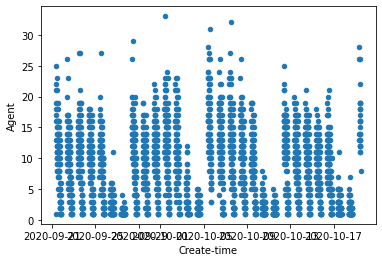

In [13]:
ignore = inflow.loc[inflow['Agent'] > 0].plot.scatter(x='Create-time', y='Agent')

In [14]:
inflow.iloc[inflow['Agent'].idxmax()]

Create-time    2020-10-01 09:10:00
Agent                           33
Name: 2881, dtype: object

In [15]:
inflow.head()

,Create-time,Agent
0,2020-09-21 09:05:00,1
1,2020-09-21 09:10:00,22
2,2020-09-21 09:15:00,25
3,2020-09-21 09:20:00,19
4,2020-09-21 09:25:00,16


In [16]:
inflow.rename(columns = {'Agent': 'ncalls'}, inplace=True)

In [17]:
inflow.head()

,Create-time,ncalls
0,2020-09-21 09:05:00,1
1,2020-09-21 09:10:00,22
2,2020-09-21 09:15:00,25
3,2020-09-21 09:20:00,19
4,2020-09-21 09:25:00,16


In [18]:
inflow.to_csv('full-inflow-1.csv', index=False)

In [22]:
data['Total-time'] = data['Total-time'].apply(lambda r: r.seconds)
total_time = data[['Create-time', 'Total-time']].groupby(pd.Grouper(key='Create-time', freq='5min')).mean()
total_time.reset_index(inplace=True)
total_time.rename(columns={'Total-time': 'Avg-time'}, inplace=True)
total_time.head()

,Create-time,Avg-time
0,2020-09-21 09:05:00,79.000000
1,2020-09-21 09:10:00,517.045455
2,2020-09-21 09:15:00,630.840000
3,2020-09-21 09:20:00,604.473684
4,2020-09-21 09:25:00,333.437500


In [23]:
total_time.loc[~total_time['Avg-time'].isnull()].head()

,Create-time,Avg-time
0,2020-09-21 09:05:00,79.000000
1,2020-09-21 09:10:00,517.045455
2,2020-09-21 09:15:00,630.840000
3,2020-09-21 09:20:00,604.473684
4,2020-09-21 09:25:00,333.437500


In [24]:
total_time.to_csv('total_time_1.csv', index=False)

In [25]:
consolidated = pd.merge(left=inflow, right=total_time, on='Create-time')

In [26]:
consolidated.head()

,Create-time,ncalls,Avg-time
0,2020-09-21 09:05:00,1,79.000000
1,2020-09-21 09:10:00,22,517.045455
2,2020-09-21 09:15:00,25,630.840000
3,2020-09-21 09:20:00,19,604.473684
4,2020-09-21 09:25:00,16,333.437500


In [27]:
def extract_period(dt):
    return str(dt)[0:10]    

consolidated['Period'] = consolidated.apply(lambda r: extract_period(r['Create-time']), axis=1)

In [28]:
nagents = ss[['Period', 'Agent']].groupby('Period').nunique()
nagents.reset_index(inplace=True)

In [29]:
nagents.head()

,Period,Agent
0,01/10/2020,64
1,02/10/2020,53
2,03/10/2020,9
3,04/10/2020,8
4,05/10/2020,58


In [30]:
def convert(d):
    yr = d[6:10]
    mn = d[3:5]
    dy = d[0:2]
    
    return yr + '-' + mn + '-' + dy

In [31]:
nagents['Period'] = nagents.apply(lambda r: convert(r['Period']), axis=1)

In [32]:
consolidated = pd.merge(left=consolidated, right=nagents, on='Period')

In [33]:
consolidated.rename(columns={'Agent': 'nagents'}, inplace=True)

In [34]:
consolidated.head()

,Create-time,ncalls,Avg-time,Period,nagents
0,2020-09-21 09:05:00,1,79.000000,2020-09-21,60
1,2020-09-21 09:10:00,22,517.045455,2020-09-21,60
2,2020-09-21 09:15:00,25,630.840000,2020-09-21,60
3,2020-09-21 09:20:00,19,604.473684,2020-09-21,60
4,2020-09-21 09:25:00,16,333.437500,2020-09-21,60


In [37]:
consolidated.shape

(8095, 5)

In [38]:
consolidated.dtypes

Create-time    datetime64[ns]
ncalls                  int64
Avg-time              float64
Period                 object
nagents                 int64
dtype: object

In [44]:
import datetime

In [55]:
consolidated.iloc[0, :][0].time() > datetime.time(9, 0)

True

In [66]:
def is_office_hour(dt):
    return dt.time() > datetime.time(9, 0) and dt.time() < datetime.time(17, 5)

consolidated['office-hour'] = consolidated.apply(lambda r: is_office_hour(r['Create-time']), axis=1)

In [67]:
consolidated.head()

,Create-time,ncalls,Avg-time,Period,nagents,office-hour
0,2020-09-21 09:05:00,1,79.000000,2020-09-21,60,True
1,2020-09-21 09:10:00,22,517.045455,2020-09-21,60,True
2,2020-09-21 09:15:00,25,630.840000,2020-09-21,60,True
3,2020-09-21 09:20:00,19,604.473684,2020-09-21,60,True
4,2020-09-21 09:25:00,16,333.437500,2020-09-21,60,True


In [69]:
C = consolidated[consolidated['office-hour'] == True]

In [70]:
C.shape

(2719, 6)

In [72]:
C.to_csv('consolidated-1.csv', index=False)